# Non-incremental online learning of parallelizable Reservoir (simple turbulence closure model)

In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

########################################
#Filter data loading

#file_path = '/content/drive/My Drive/Colab Notebooks/flt_kanto_wind_speed_hourly.csv'

#data = pd.read_csv(file_path)
#data = np.array(data, dtype=float)
#data = data.T

########################################
#Original data loading

file_path_org = '/content/drive/My Drive/Colab Notebooks/tokyo_region_wind_speed_hourly.csv'

data_org = pd.read_csv(file_path_org)
data_org = np.array(data_org)
data_org = data_org[1:,1:]
data_org = np.array(data_org, dtype=float)

data_org = data_org.T

#print('Filter data shape:',data.shape)
print('Original data shape:',data_org.shape)

Mounted at /content/drive
Original data shape: (42, 4367)


In [2]:
# @title Loading optuna

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.5 MB/s eta 0:00:00


In [3]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

def generate_random_binary_matrix(N_x, dim, density, seed_value_binary):

    num_ones = int(N_x*dim * density)

    matrix = np.zeros(N_x*dim, dtype=int)

    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*dim, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, dim))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

#############################
# reservoir state vector
#############################

def Reservoir(x_in,x,W,alpha,bias_scale):

        Wbias = np.ones(len(x_in))
        Wbias = Wbias * bias_scale

        x = (1.0 - alpha) * x \
                 + alpha * np.tanh(np.dot(W, x)+Wbias \
                 + x_in)
        return x

############################
#Ridge Regression and  Output Weight Matrix
############################

def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):


    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))

    for m in range(train_U.shape[0]):

        x = np.zeros(N_x)

        for n in range(T_train):

            # reservoir state vector
            x = Reservoir(np.dot(Win,train_U[m,n,:]),x,W,alpha,bias_scale)

            # teacher data
            d = train_D[m,n,:]


            if n > discard_len:  # discard the first part of the data
                 X_XT, D_XT = Ridge(d, x, X_XT, D_XT)

        x_special_vec[m,:] = x

    return X_XT, D_XT,x_special_vec


########################
#induction formula for creating estimated data
########################

def run(test_U,x,Win,W,Wout,alpha,T_test,bias_scale):


    Y_pred = []
    y = test_U[0,:]


    for n in range(T_test):

        x = Reservoir(np.dot(Win,y),x,W,alpha,bias_scale)
        y_pred = np.dot(Wout, x)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):

    mae = mean_absolute_error(data1_in, data2_in)
    return mae

In [4]:
# @title Definition of train-test (model selection, using optuna）

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

def objective(trial):
    lag = trial.suggest_int("lag", max_lag, max_lag)
    dim = trial.suggest_int("dim", max_dim, max_dim)
    N_x = trial.suggest_int("N_x", Node, Node)
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density = trial.suggest_float("density", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho = trial.suggest_float("rho", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value = trial.suggest_float("seed_value", 0, 100)
    bias_scale = trial.suggest_float("bias_scale", -1.5, 1.5)

#Test start time (model selection)

    T_0 = T_train + lag * dim

#Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)

###############
    data_delay_train = np.zeros((impl_set.shape[0],T_train+1,dim), dtype=float)
    test_Y           = np.zeros((impl_set.shape[0],T_test,test_num))
    test_D           = np.zeros((impl_set.shape[0],T_test,test_num))
###############
#Convert data to a delay coordinate system

    for i in range(dim):

        data_delay_train[:,:,i] = impl_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag Step-delayed time series

# Initialization of training data

    train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:,:T_train,:]
    train_D = data_delay_train[:,1:T_train+1,:]

##Online: The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, \
                                  Win, W, N_x, dim, alpha,discard_len,bias_scale)

# Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###############
    data_delay_test         = np.zeros((T_test+1,dim,test_num), dtype=float)
    #data_delay_test_org     = np.zeros((T_test+1,dim,test_num), dtype=float)
    tentative_test_Y        = np.zeros((T_test,dim,test_num))
    data_delay_train_resvec = np.zeros((impl_set.shape[0],T_train+1,dim,test_num), dtype=float)
###############

#Convert training data to a delay coordinate system

    for t in range(test_num):

        for i in range(dim):

            data_delay_train_resvec[:,:,i,t] = impl_set[:,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

# Initialization of training data

        train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
        train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)

#Input/output of training data

        train_U[:,:,:] = data_delay_train_resvec[:,:T_train,:,t]
        train_D[:,:,:] = data_delay_train_resvec[:,1:T_train+1,:,t]

##Online: The last time data of the training data output must overlap with the test data!

    #Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        _, _,x_special_vec = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)

#######################
#Convert test data to a delay coordinate system

        for j in range (impl_set.shape[0]):

            for i in range(dim):

                data_delay_test[:,i,t] = impl_set[j,T_0-i*lag+t:
                                                T_0+T_test-i*lag+t+1] # i*lag step delayed time series

#Generate estimated data

            tentative_test_Y[:,:,t] = run(data_delay_test[:T_test,:,t],x_special_vec[j,:], \
                                          Win,W,Wout,alpha,T_test,bias_scale)
            test_Y[j,:,t] = tentative_test_Y[:,0,t]
            test_D[j,:,t] = data_delay_test[1:T_test+1,0,t]

    return MAE(test_Y[:,T_test-1,:],test_D[:,T_test-1,:])

In [5]:
# @title Hyper parameters

T_train      = 1000 # Training period
T_test       = 3    # Forecast period
discard_len  = 10   # Number of steps not learned at the beginning (not important)
initial_time = 0    # Starting time of training


n_trials    = 40    # Number of times to test with optuna (generate MAE for this number of times)

Node       = 80     # Reservoir Node
max_lag    = 1      # Maximum of lag for delay coordinate
max_dim    = 4      # Maximum of dimension for delay coordinate
test_num   = 1      # test numbers for each time series

width = 19          # width of the filter

MAX_TRIALS = 30     # Repeat the same thing while shifting each one step to produce robust result

In [6]:
# @title Bayesian optimization of Reservoir

%%time

###############################

print("data_org.shape:",data_org.shape)
print("data_org length from initial_time:",data_org[:,initial_time:].shape[1])
print("requirement of data length for one train-test:",T_train+max_lag*max_dim+2*T_test+test_num)

###############################

mean_score     = []
score          = []

mean_score_m_per_sec     = []
score_m_per_sec          = []

###############################
#Convert data to Implement set for each trial

for trial in range(MAX_TRIALS):
    print(f"Trial {trial + 1}/{MAX_TRIALS}")

    #impl_set     = data[:,initial_time+trial:initial_time+T_train+max_lag*max_dim+2*T_test+test_num+trial]

    """
    ML by original data, we need to set impl_set as below
    """
    impl_set = data_org[:,initial_time+trial+width:initial_time+T_train+max_lag*max_dim+2*T_test+test_num+trial+width]
    ##################


    ########################
    #standardization for each train-test (implement set)

    mean_value = np.mean(impl_set)
    std_dev    = np.std(impl_set)
    impl_set = (impl_set - mean_value) / std_dev

    # mean_value_org = np.mean(impl_set_org)
    # std_dev_org    = np.std(impl_set_org)
    # impl_set_org = (impl_set_org - mean_value_org) / std_dev_org
    ########################
    #Visualization

    a = 0

    plt.figure(figsize=(8, 3))
    plt.subplot(2, 1, 1)
    plt.plot(impl_set[a,],color="black", label=f"flt data")
    # plt.plot(impl_set_org[a,], color = "red",label=f"org data")
    plt.title(f"Original data No.{a}")
    plt.xlabel('steps')
    plt.ylabel('standardized value')

    plt.tight_layout()
    plt.show()
    #######################
    #Early stopping
    def stop_callback(study, trial):

        if study.best_value < 0.01:
            study.stop()

    #Implement Optuna
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials, callbacks=[stop_callback])


    print("Best trial:")
    trial = study.best_trial
    print(f"  'params': {trial.params},")
    print(f"  'value': {trial.value},")

    lag         = trial.params["lag"]
    dim         = trial.params["dim"]
    N_x         = trial.params["N_x"]
    beta        = trial.params["beta"]
    density     = trial.params["density"]
    input_scale = trial.params["input_scale"]
    rho         = trial.params["rho"]
    alpha       = trial.params["alpha"]
    seed_value  = trial.params["seed_value"]
    bias_scale  = trial.params["bias_scale"]

###################################
##Test phase
###################################
    #Test start time (model evaluation)

    T_0 = T_train+lag*dim+T_test+test_num-1

    #Fix input and recurrent weight matrices

    Win = input_matrix(N_x,seed_value,input_scale,dim)
    W   = recurrent_matrix(N_x, density, rho,seed_value)

    #Convert test data to a delay coordinate system

    data_delay_train = np.zeros((impl_set.shape[0],T_train+1,dim), dtype=float)

    for i in range(dim):

        data_delay_train[:,:,i] = impl_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag step delayed time series

    # Initialization of training data

    train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)


    #Input/output of training data

    train_U = data_delay_train[:,:T_train,:]
    train_D = data_delay_train[:,1:T_train+1,:]

    ##The last time data of the training data output must overlap with the test data!

    #Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)

    #Generate output weight matrix
    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

    ######################################
    # initialization
    data_delay_train_resvec = np.zeros((T_train+1,dim,test_num), dtype=float)
    data_delay_test         = np.zeros((T_test+1,dim,test_num), dtype=float)
    test_Y                  = np.zeros((T_test,test_num))
    test_D                  = np.zeros((T_test,test_num))
    tentative_test_Y        = np.zeros((T_test,dim,test_num))
    mae                     = np.zeros((impl_set.shape[0]),dtype=float)
    ######################################
    ##Convert training data to a delay coordinate system (to create reservoir state vec)

    for j in range (impl_set.shape[0]):

        for t in range(test_num):

            for i in range(dim):

                  data_delay_train_resvec[:,i,t] = impl_set[j,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

        # Initialization of training data

            train_U = np.zeros((1,T_train,dim), dtype=float)
            train_D = np.zeros((1,T_train,dim), dtype=float)

        #Input/output of training data

            train_U[0,:,:] = data_delay_train_resvec[:T_train,:,t]
            train_D[0,:,:] = data_delay_train_resvec[1:T_train+1,:,t]

        ##The last time data of the training data output must overlap with the test data!

        #Ridge
            X_XT = np.zeros((N_x, N_x))
            D_XT = np.zeros((dim, N_x))
            x_special = np.zeros((1,N_x))

            _, _,x_special = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)


            x_special = x_special.flatten()


            #Convert test data to a delay coordinate system

            for i in range(dim):

                  data_delay_test[:,i,t] = impl_set[j,T_0+t-i*lag
                                                :T_0+t+T_test-i*lag+1] # i*lag step delayed time series

          #Predictive data generation

            tentative_test_Y[:,:,t] = run(data_delay_test[:T_test,:,t],x_special,Win,W,Wout,alpha,T_test,bias_scale)
            test_Y[:,t] = tentative_test_Y[:,0,t]
            test_D[:,t] = data_delay_test[1:T_test+1,0,t]

            #############################
            # Running Test Predictions
            if j == a:
                plt.figure(figsize=(7, 3))
                plt.plot(test_Y[:,t], color = "black",label=f"specific pred No.{a}")
                plt.plot(test_D[:,t], color = "red",label=f"specific original-data No.{a}")
                plt.legend()#loc='lower right')
                plt.xlabel('Time')
                plt.ylabel('Amplitude')
                plt.grid(which='major', linestyle='--', axis='both')

                plt.show()
            #############################

        mae[j] = MAE( test_Y[T_test-1,:],test_D[T_test-1,:])

    score.append(np.mean(mae))
    mean_score.append(np.mean(score))
    score_m_per_sec.append(np.mean(std_dev) *np.mean(mae))
    mean_score_m_per_sec.append(np.mean(score_m_per_sec))

    print('MAE standard:',np.mean(mae))
    print('Average of MAE standard:',np.mean(score))
    print('m/s MAE:',np.mean(std_dev) * np.mean(mae))
    print('Ave m/s MAE:',np.mean(score_m_per_sec))

Output hidden; open in https://colab.research.google.com to view.

Average of MAE standard: 0.4475304102960217
Ave m_per_sec MAE: 4.053351647572038


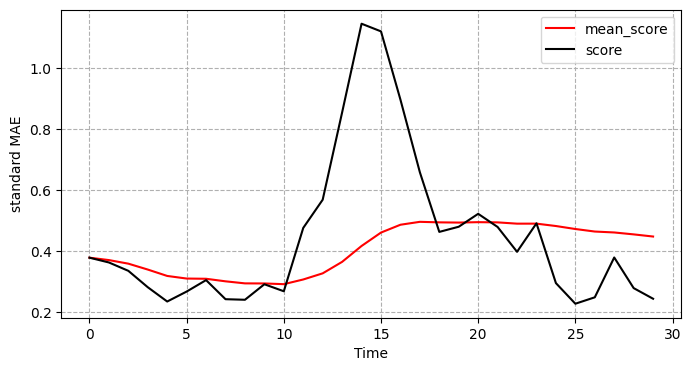

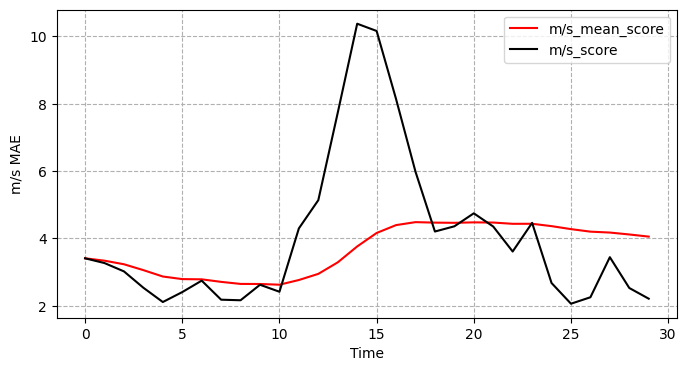

In [7]:
# @title Result with robustness

mean_score = [float(x) for x in mean_score]

import matplotlib.pyplot as plt


print('Average of MAE standard:',mean_score[MAX_TRIALS-1])
print('Ave m_per_sec MAE:',mean_score_m_per_sec[MAX_TRIALS-1])

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(mean_score, color = "red",label=f"mean_score")
plt.plot(score, color = "black",label=f"score")
plt.legend()
plt.xlabel('Time')
plt.ylabel('standard MAE')
plt.grid(which='major', linestyle='--', axis='both')

plt.figure(figsize=(8, 4))
plt.plot(mean_score_m_per_sec, color = "red",label=f"m/s_mean_score")
plt.plot(score_m_per_sec, color = "black",label=f"m/s_score")
plt.legend()
plt.xlabel('Time')
plt.ylabel('m/s MAE')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()